# Post-processing Prompt Collective


In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
from collections import Counter


def unify_responses(rec):
    counter = Counter()
    total_quality = 0
    num_responses = 0
    rating_values = []

    responses = [resp for resp in rec["quality"] if resp["status"] == "submitted"]
    raw_responses = [int(resp["value"]) + 1 for resp in responses]
    for resp in responses:
        quality = int(resp["value"]) + 1
        rating_values.append(quality)
        counter.update([quality])
        total_quality += quality
        num_responses += 1

    average_quality = total_quality / num_responses

    # Compute raw agreement
    most_common_count = counter.most_common(1)[0][1]
    raw_agreement = most_common_count / num_responses

    # Adjust the raw agreement to scale from 0 (no agreement) to 1 (full agreement)
    # The adjustment here is more heuristic and might need more refinement
    agreement = (raw_agreement - 1 / 5) / (1 - 1 / 5)

    return {
        "avg_rating": average_quality,
        "num_responses": num_responses,
        "agreement_ratio": agreement,
        "raw_responses": raw_responses,
    }

In [3]:
from datasets import load_dataset

dataset = load_dataset(
    "DIBT/10k-prompt-collective-argilla-format",
)
dataset

/home/ben/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['prompt', 'quality', 'quality-suggestion', 'quality-suggestion-metadata', 'external_id', 'metadata'],
        num_rows: 10331
    })
})

In [4]:
processed_dataset = dataset.map(unify_responses)

# Inter rater agreement


In [5]:
!pip install krippendorff

In [6]:
import numpy as np
from collections import defaultdict
import krippendorff


def prepare_reliability_data(data):
    # Extract unique raters across all units
    unique_raters = set()
    for unit_responses in data:
        for response in unit_responses:
            unique_raters.add(response["user_id"])

    # Map raters to column indices
    rater_to_index = {rater: index for index, rater in enumerate(unique_raters)}

    # Initialize the reliability data matrix with NaNs
    reliability_data = np.full((len(data), len(unique_raters)), np.nan)

    # Populate the matrix with ratings
    for unit_index, unit_responses in enumerate(data):
        for response in unit_responses:
            if response["status"] == "submitted":
                rater_index = rater_to_index[response["user_id"]]
                rating = int(response["value"]) + 1  # Adjust rating as necessary
                reliability_data[unit_index, rater_index] = rating

    return reliability_data.T


df = processed_dataset["train"].to_pandas()
recs = df.loc[df.num_responses >= 2]["quality"]
reliability_data = prepare_reliability_data(recs)
alpha_score = krippendorff.alpha(
    reliability_data=reliability_data, level_of_measurement="ordinal"
)
alpha_score = round(alpha_score, 3)
print(f"krippendorff's alpha: {alpha_score}")

krippendorff's alpha: 0.291


# Rating at Labels


In [7]:
import pandas as pd


def rating_at_labels(df):
    df = df.loc[df.num_responses >= 2]

    # Create bins for the 'avg_rating' column
    bins = pd.cut(df["avg_rating"], bins=5)

    label_rating = pd.Series()
    # Group the DataFrame by these bins and count the rows in each bin
    for bin, avg_rating in df.groupby(bins)["avg_rating"]:
        _df = df.loc[avg_rating.index]
        alpha_score = krippendorff.alpha(
            reliability_data=prepare_reliability_data(_df["quality"]),
            level_of_measurement="ordinal",
        )
        label_rating[bin] = alpha_score
    return label_rating


label_rating = rating_at_labels(df)

/tmp/ipykernel_115828/1502083243.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin, avg_rating in df.groupby(bins)["avg_rating"]:


<Axes: title={'center': "Krippendorff's Alpha by Average Rating"}, xlabel="Krippendorff's Alpha", ylabel='Average Rating'>

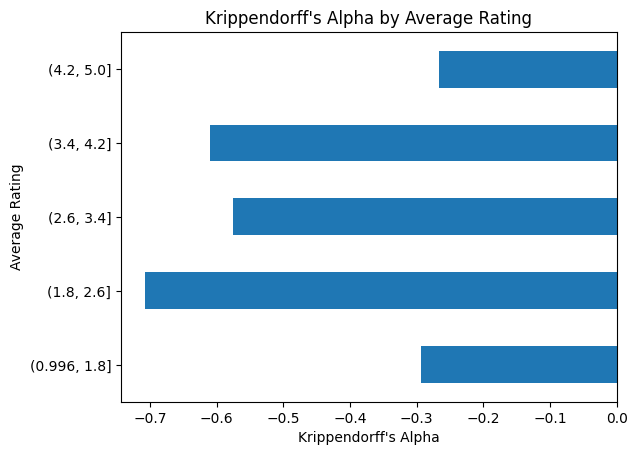

In [8]:
# set axis labels

label_rating.plot(
    kind="barh",
    title="Krippendorff's Alpha by Average Rating",
    ylabel="Average Rating",
    xlabel="Krippendorff's Alpha",
)

# Agreement by user


In [9]:
user_df = df.explode("quality")
user_df["user_id"] = user_df["quality"].apply(lambda x: x.get("user_id"))

## User agreement by average rating


In [10]:
user_df.groupby("user_id")["avg_rating"].describe()

count      mean       std  min  \
user_id                                                                 
0092c596-7348-4760-ad34-6790169a95fa    66.0  3.451010  1.012139  1.0   
03612c05-3c69-48fc-8bc1-624b436b1906    65.0  3.507253  0.802303  2.0   
0383bb61-7cc6-4025-943f-411864163fb2    10.0  3.415000  0.828149  2.4   
0583afc2-2cd8-43b6-a61b-d73dbf2ad9d9  2512.0  3.786663  0.829184  1.0   
067b1ce7-25f9-4cfd-a9cb-e95eba158c4b    23.0  3.344203  1.338132  1.0   
...                                      ...       ...       ...  ...   
fae7553a-e4d2-471d-96cc-78a7a094fb2c    14.0  3.630952  1.033992  2.0   
fbc67e4b-8b9e-4aa3-9ffe-277c0ee46f65     3.0  3.000000  1.000000  2.0   
fc6528f0-10ca-461d-82d1-3501fbc1b826     3.0  4.246032  0.647835  3.5   
fc7fe6c4-9027-4095-b86e-534cdc85efb1     3.0  4.166667  0.577350  3.5   
ffa4cef0-0919-4470-91cb-6a1fc41bffe7   110.0  3.670152  0.903307  1.0   

                                           25%       50%       75%       max  
user_id                                                                       
0092c596-7348-4760-ad34-6790169a95fa  3.000000  3.500000  4.000000  5.000000  
03612c05-3c69-48fc-8bc1-624b436b1906  3.000000  4.000000  4.000000  5.000000  
0383bb61-7cc6-4025-943f-411864163fb2  2.750000  3.291667  4.000000  5.000000  
0583afc2-2cd8-43b6-a61b-d73dbf2ad9d9  3.000000  4.000000  4.500000  5.000000  
067b1ce7-25f9-4cfd-a9cb-e95eba158c4b  2.125000  4.000000  4.166667  5.000000  
...                                        ...       ...       ...       ...  
fae7553a-e4d2-471d-96cc-78a7a094fb2c  3.125000  4.000000  4.000000  5.000000  
fbc67e4b-8b9e-4aa3-9ffe-277c0ee46f65  2.500000  3.000000  3.500000  4.000000  
fc6528f0-10ca-461d-82d1-3501fbc1b826  4.035714  4.571429  4.619048  4.666667  
fc7fe6c4-9027-4095-b86e-534cdc85efb1  4.000000  4.500000  4.500000  4.500000  
ffa4cef0-0919-4470-91cb-6a1fc41bffe7  3.000000  4.000000  4.333333  5.000000  

[314 rows x 8 columns]

In [11]:
bins = pd.cut(user_df["avg_rating"], bins=5)

avg_rating_agreement = pd.Series()
for bin, avg_rating in user_df.groupby(bins)["avg_rating"]:
    _user_df = user_df.loc[avg_rating.index]
    _df_quality = _user_df.groupby(level=0)["quality"].apply(list)
    alpha_score = krippendorff.alpha(
        reliability_data=prepare_reliability_data(_df_quality),
        level_of_measurement="ordinal",
    )
    avg_rating_agreement[bin] = alpha_score

/tmp/ipykernel_115828/2558243833.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin, avg_rating in user_df.groupby(bins)["avg_rating"]:


<Axes: title={'center': "Krippendorff's Alpha by User Average Rating"}, xlabel="Krippendorff's Alpha", ylabel='User Average Rating'>

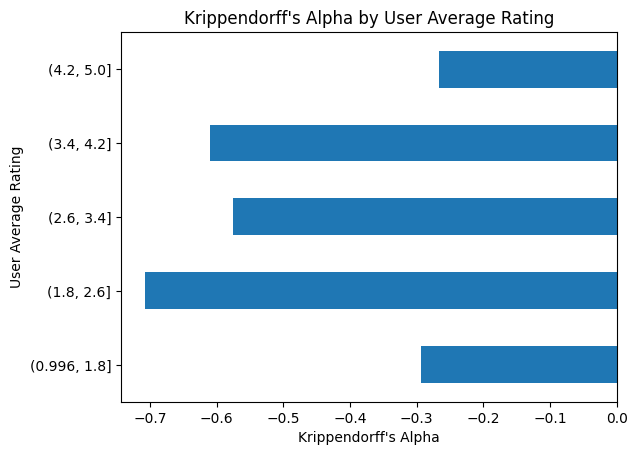

In [12]:
# add title and axis labels
avg_rating_agreement.plot(
    kind="barh",
    title="Krippendorff's Alpha by User Average Rating",
    ylabel="User Average Rating",
    xlabel="Krippendorff's Alpha",
)

## User agreement by agreement ratio


In [13]:
user_df.groupby("user_id")["agreement_ratio"].describe()

count      mean       std       min  \
user_id                                                                      
0092c596-7348-4760-ad34-6790169a95fa    66.0  0.766098  0.311179  0.166667   
03612c05-3c69-48fc-8bc1-624b436b1906    65.0  0.805540  0.287275  0.166667   
0383bb61-7cc6-4025-943f-411864163fb2    10.0  0.495833  0.356515  0.166667   
0583afc2-2cd8-43b6-a61b-d73dbf2ad9d9  2512.0  0.795195  0.291165  0.062500   
067b1ce7-25f9-4cfd-a9cb-e95eba158c4b    23.0  0.773551  0.294045  0.375000   
...                                      ...       ...       ...       ...   
fae7553a-e4d2-471d-96cc-78a7a094fb2c    14.0  0.747024  0.318359  0.166667   
fbc67e4b-8b9e-4aa3-9ffe-277c0ee46f65     3.0  0.791667  0.360844  0.375000   
fc6528f0-10ca-461d-82d1-3501fbc1b826     3.0  0.474206  0.104520  0.375000   
fc7fe6c4-9027-4095-b86e-534cdc85efb1     3.0  0.375000  0.000000  0.375000   
ffa4cef0-0919-4470-91cb-6a1fc41bffe7   110.0  0.724811  0.292459  0.166667   

                                           25%       50%      75%       max  
user_id                                                                      
0092c596-7348-4760-ad34-6790169a95fa  0.375000  1.000000  1.00000  1.000000  
03612c05-3c69-48fc-8bc1-624b436b1906  0.583333  1.000000  1.00000  1.000000  
0383bb61-7cc6-4025-943f-411864163fb2  0.250000  0.375000  0.84375  1.000000  
0583afc2-2cd8-43b6-a61b-d73dbf2ad9d9  0.375000  1.000000  1.00000  1.000000  
067b1ce7-25f9-4cfd-a9cb-e95eba158c4b  0.375000  1.000000  1.00000  1.000000  
...                                        ...       ...      ...       ...  
fae7553a-e4d2-471d-96cc-78a7a094fb2c  0.427083  1.000000  1.00000  1.000000  
fbc67e4b-8b9e-4aa3-9ffe-277c0ee46f65  0.687500  1.000000  1.00000  1.000000  
fc6528f0-10ca-461d-82d1-3501fbc1b826  0.419643  0.464286  0.52381  0.583333  
fc7fe6c4-9027-4095-b86e-534cdc85efb1  0.375000  0.375000  0.37500  0.375000  
ffa4cef0-0919-4470-91cb-6a1fc41bffe7  0.375000  0.875000  1.00000  1.000000  

[314 rows x 8 columns]

In [14]:
avg_rating_agreement = {}
bins = pd.cut(user_df["agreement_ratio"], bins=5)

for bin_range, grouped_df in user_df.groupby(bins):
    _df_quality = grouped_df.groupby(level=0)["quality"].apply(list)
    _df_quality = _df_quality.loc[_df_quality.apply(len) >= 2]
    if len(_df_quality) >= 10:
        reliability_data = prepare_reliability_data(_df_quality)
        alpha_score = krippendorff.alpha(
            reliability_data=reliability_data, level_of_measurement="ordinal"
        )
        avg_rating_agreement[bin_range] = alpha_score


avg_rating_agreement = pd.Series(avg_rating_agreement)

/tmp/ipykernel_115828/3295316802.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_range, grouped_df in user_df.groupby(bins):


<Axes: title={'center': "Krippendorff's Alpha by User Agreement Ratio"}, xlabel="Krippendorff's Alpha", ylabel='User Agreement Ratio'>

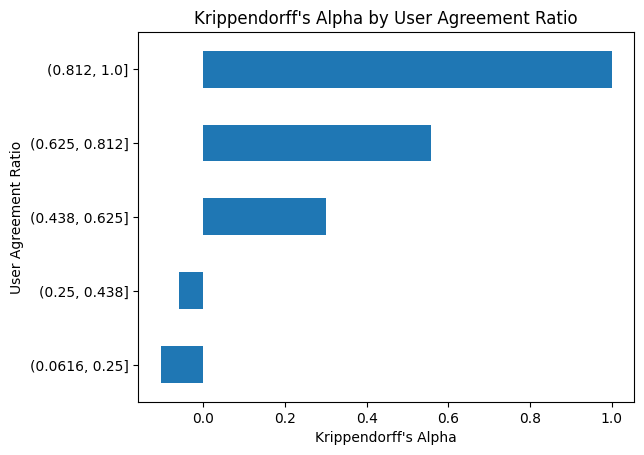

In [15]:
avg_rating_agreement.plot(
    kind="barh",
    title="Krippendorff's Alpha by User Agreement Ratio",
    ylabel="User Agreement Ratio",
    xlabel="Krippendorff's Alpha",
)

# Filter on deviation of ratings


<Axes: ylabel='raw_responses'>

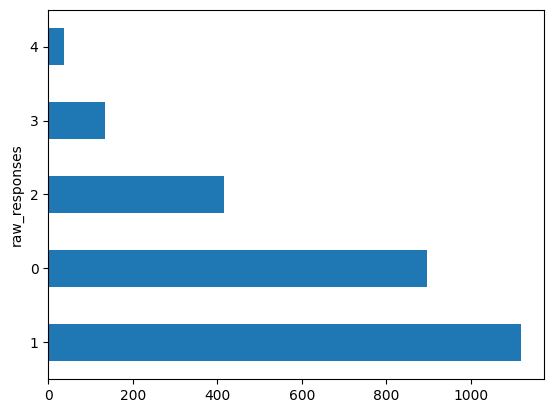

In [16]:
df = df.loc[df.num_responses == 2]
df["raw_responses"].apply(lambda x: max(x) - min(x)).value_counts().plot.barh()

In [17]:
df["diff_max_min"] = df["raw_responses"].apply(lambda x: max(x) - min(x))

In [18]:
bins = pd.cut(df["diff_max_min"], bins=2)

diff_max_min_agreement = pd.Series()
for bin, diff_max_min in df.groupby(bins)["diff_max_min"]:
    _df = df.loc[diff_max_min.index]
    alpha_score = krippendorff.alpha(
        reliability_data=prepare_reliability_data(_df["quality"]),
        level_of_measurement="ordinal",
    )
    diff_max_min_agreement[bin] = alpha_score

/tmp/ipykernel_115828/482961092.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin, diff_max_min in df.groupby(bins)["diff_max_min"]:


<Axes: title={'center': "Krippendorff's Alpha by Average Rating"}, xlabel="Krippendorff's Alpha", ylabel='Average Rating'>

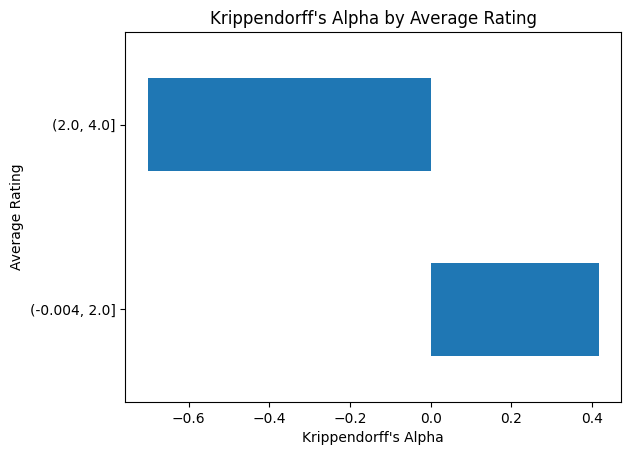

In [19]:
# set axis labels

diff_max_min_agreement.plot(
    kind="barh",
    title="Krippendorff's Alpha by Average Rating",
    ylabel="Average Rating",
    xlabel="Krippendorff's Alpha",
)

In [20]:
prepare_reliability_data(_df["quality"])

array([[nan, nan, nan, ..., nan, nan, nan],
       [ 5., nan, nan, ..., nan, nan,  1.],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [21]:
bins.value_counts()

diff_max_min
(-0.004, 2.0]    2429
(2.0, 4.0]        171
Name: count, dtype: int64

# Load synthetic reviews dataset


In [5]:
from datasets import load_dataset

synthetic_dataset = load_dataset(
    "argilla/DIBT_prompts_ranked_synthetic_n3_s1000",
    split="train",
)

In [81]:
processed_synthetic_dataset = synthetic_dataset.map(unify_responses)

Map: 100%|██████████| 12000/12000 [00:03<00:00, 3468.52 examples/s]


In [82]:
df = processed_synthetic_dataset.to_pandas()
df.head()

input  \
0  Provide step-by-step instructions on how to ma...   
1  Write a personal essay of at least 1000 words ...   
2  In this research, we aim to investigate how te...   
3  Did Karl Marx's theories on centralizing credi...   
4  alter this api that gets a request like: {"0",...   

                                             quality  \
0  [{'status': 'submitted', 'user_id': 'd23b12c2-...   
1  [{'status': 'submitted', 'user_id': '6621c3f0-...   
2  [{'status': 'submitted', 'user_id': '2e6dda25-...   
3  [{'status': 'submitted', 'user_id': 'd23b12c2-...   
4  [{'status': 'submitted', 'user_id': '99a4bc7d-...   

                                            metadata  avg_rating  \
0  {"source": "ultrachat", "kind": "synthetic", "...    5.000000   
1  {"source": "ultrachat", "kind": "synthetic", "...    2.750000   
2  {"source": "evol_instruct", "kind": "synthetic...    3.000000   
3  {"source": "OpenAssistant/oasst2", "kind": "hu...    3.500000   
4  {"source": "ewof/sharegpt-instruct-unfiltered-...    3.666667   

   num_responses  agreement_ratio raw_responses       kind  \
0              2         1.000000        [5, 5]  synthetic   
1              4         0.687500  [2, 3, 3, 3]  synthetic   
2              3         0.166667     [3, 5, 1]  synthetic   
3              2         0.375000        [4, 3]      human   
4              3         0.583333     [5, 3, 3]      human   

       generation_model                                  generation_prompt  \
0  [gpt-4-1106-preview]  [[{'content': 'You are an AI prompt evaluator ...   
1  [gpt-4-1106-preview]  [[{'content': 'You are an AI prompt evaluator ...   
2  [gpt-4-1106-preview]  [[{'content': 'You are an AI prompt evaluator ...   
3  [gpt-4-1106-preview]  [[{'content': 'You are an AI prompt evaluator ...   
4  [gpt-4-1106-preview]  [[{'content': 'You are an AI prompt evaluator ...   

                            raw_generation_responses rating  \
0  [<rating>4</rating>\n<rationale>The prompt is ...  [4.0]   
1  [<rating>5</rating>\n<rationale>The prompt is ...  [5.0]   
2  [<rating>4</rating>\n<rationale>The prompt pre...  [4.0]   
3  [<rating>4</rating>\n<rationale>The prompt is ...  [4.0]   
4  [<rating>2</rating>\n<rationale>The prompt sug...  [2.0]   

                                           rationale generations  
0  [The prompt is clear in its intent, asking for...        None  
1  [The prompt is very clear in its intent, askin...        None  
2  [The prompt presents a clear and specific rese...        None  
3  [The prompt is clear in its intent, asking for...        None  
4  [The prompt suggests a goal of altering an API...        None

In [83]:
recs = df.loc[df.num_responses >= 2]["quality"]
reliability_data = prepare_reliability_data(recs)
alpha_score = krippendorff.alpha(
    reliability_data=reliability_data, level_of_measurement="ordinal"
)
alpha_score = round(alpha_score, 3)
print(f"krippendorff's alpha: {alpha_score}")

krippendorff's alpha: 0.31


In [84]:
df = df.loc[df.rating.apply(lambda r: r is not None)]
df["hash"] = df.input.apply(hash)
df["synth_rating"] = df.rating.apply(lambda x: x[0])
df["synth_model"] = df.generation_model.apply(lambda x: x[0])
df["human_rating"] = df["avg_rating"]
df["human_ratings"] = df["raw_responses"]

for model in df.synth_model.unique():
    df[f"{model}_rating"] = df.apply(
        lambda row: row.rating[0] if row.generation_model[0] == model else None, axis=1
    )

In [85]:
agg_dict = {
    "synth_rating": list,
    "human_rating": lambda x: np.mean(x).round(0),
    "synth_model": list,
    "human_ratings": "first",
    "quality": "first",
}

for model in df.synth_model.unique():
    agg_dict[f"{model}_rating"] = "first"


grouped_df = df.groupby("hash").aggregate(agg_dict)

In [92]:
grouped_df

synth_rating  human_rating  \
hash                                                  
-9219888060000337674            [2.0]           1.0   
-9219058305524562566            [4.0]           4.0   
-9208527868346278411            [3.0]           3.0   
-9208033226661376403            [4.0]           5.0   
-9205719860821429870  [1.0, 3.0, 1.0]           2.0   
...                               ...           ...   
 9215440054381754504            [4.0]           4.0   
 9215810989656221571            [3.0]           3.0   
 9216126492275130339            [5.0]           4.0   
 9219804065265528012            [5.0]           4.0   
 9220625076015600356            [4.0]           1.0   

                                                            synth_model  \
hash                                                                      
-9219888060000337674                               [gpt-4-1106-preview]   
-9219058305524562566                               [gpt-4-1106-preview]   
-9208527868346278411                               [gpt-4-1106-preview]   
-9208033226661376403                               [gpt-4-1106-preview]   
-9205719860821429870  [gpt-4-1106-preview, gpt-3.5-turbo-1106, gpt-4...   
...                                                                 ...   
 9215440054381754504                               [gpt-4-1106-preview]   
 9215810989656221571                               [gpt-4-1106-preview]   
 9216126492275130339                               [gpt-4-1106-preview]   
 9219804065265528012                               [gpt-4-1106-preview]   
 9220625076015600356                               [gpt-4-1106-preview]   

                     human_ratings  \
hash                                 
-9219888060000337674           [1]   
-9219058305524562566           [4]   
-9208527868346278411           [3]   
-9208033226661376403           [5]   
-9205719860821429870     [1, 4, 1]   
...                            ...   
 9215440054381754504        [4, 3]   
 9215810989656221571           [3]   
 9216126492275130339           [4]   
 9219804065265528012        [4, 5]   
 9220625076015600356           [1]   

                                                                quality  \
hash                                                                      
-9219888060000337674  [{'status': 'submitted', 'user_id': 'e2bdd868-...   
-9219058305524562566  [{'status': 'submitted', 'user_id': '7042ec82-...   
-9208527868346278411  [{'status': 'submitted', 'user_id': 'f1975dd0-...   
-9208033226661376403  [{'status': 'submitted', 'user_id': '33e4b415-...   
-9205719860821429870  [{'status': 'submitted', 'user_id': 'db49f3a6-...   
...                                                                 ...   
 9215440054381754504  [{'status': 'submitted', 'user_id': '7042ec82-...   
 9215810989656221571  [{'status': 'submitted', 'user_id': '335dc16a-...   
 9216126492275130339  [{'status': 'submitted', 'user_id': '57bfca01-...   
 9219804065265528012  [{'status': 'submitted', 'user_id': 'dec68aa0-...   
 9220625076015600356  [{'status': 'submitted', 'user_id': '7042ec82-...   

                      gpt-4-1106-preview_rating  gpt-3.5-turbo-1106_rating  \
hash                                                                         
-9219888060000337674                        2.0                        NaN   
-9219058305524562566                        4.0                        NaN   
-9208527868346278411                        3.0                        NaN   
-9208033226661376403                        4.0                        NaN   
-9205719860821429870                        1.0                        3.0   
...                                         ...                        ...   
 9215440054381754504                        4.0                        NaN   
 9215810989656221571                        3.0                        NaN   
 9216126492275130339                        5.0                        NaN   
 921

In [87]:
def wrangle_model_quality(row):
    quality = []
    for model, rating in zip(row["synth_model"], row["synth_rating"]):
        if rating is not None:
            quality.append(
                {
                    "user_id": model,
                    "value": rating,
                    "status": "submitted",
                }
            )
    return quality


grouped_df["synth_quality"] = grouped_df.apply(wrangle_model_quality, axis=1)

In [88]:
pd.DataFrame(grouped_df["synth_quality"].explode().values)

0
0      {'user_id': 'gpt-4-1106-preview', 'value': 2.0...
1      {'user_id': 'gpt-4-1106-preview', 'value': 4.0...
2      {'user_id': 'gpt-4-1106-preview', 'value': 3.0...
3      {'user_id': 'gpt-4-1106-preview', 'value': 4.0...
4      {'user_id': 'gpt-4-1106-preview', 'value': 1.0...
...                                                  ...
11929  {'user_id': 'gpt-4-1106-preview', 'value': 4.0...
11930  {'user_id': 'gpt-4-1106-preview', 'value': 3.0...
11931  {'user_id': 'gpt-4-1106-preview', 'value': 5.0...
11932  {'user_id': 'gpt-4-1106-preview', 'value': 5.0...
11933  {'user_id': 'gpt-4-1106-preview', 'value': 4.0...

[11934 rows x 1 columns]

In [89]:
import numpy as np

reliability_data = prepare_reliability_data(grouped_df["synth_quality"])
alpha_score = krippendorff.alpha(
    reliability_data=reliability_data,
    level_of_measurement="ordinal",
)
print(alpha_score)

0.6104811609546226


In [94]:
from itertools import chain

aggregated_agreement = []


def aggregate_agreements(grouped_df, raters):
    aggregated_agreement = []
    for model in raters:
        for rating, _df in grouped_df.groupby(f"{model}_rating"):
            if len(_df) < 2:
                continue

            # SYNTH

            reliability_data = np.array(
                _df["synth_rating"]
                .loc[_df["synth_rating"].apply(lambda x: len(x) > 2)]
                .to_list()
            ).T
            alpha_score = krippendorff.alpha(
                reliability_data=reliability_data,
                level_of_measurement="ordinal",
            )

            aggreement_dict = {
                "rating": rating,
                "synth_alpha": alpha_score,
                "num_units": len(_df),
                "rater": model,
            }

            # HUMAN

            reliability_data = prepare_reliability_data(_df["quality"])

            alpha_score = krippendorff.alpha(
                reliability_data=reliability_data,
                level_of_measurement="ordinal",
            )

            aggreement_dict["human_alpha"] = alpha_score

            aggregated_agreement.append(aggreement_dict)

            # COMBINED

            combined_quality = _df.apply(
                lambda row: list(row["quality"]) + list(row["synth_quality"]), axis=1
            )

            reliability_data = prepare_reliability_data(combined_quality)

            alpha_score = krippendorff.alpha(
                reliability_data=reliability_data,
                level_of_measurement="ordinal",
            )

            aggreement_dict["combined_alpha"] = alpha_score
    aggregated_agreement = pd.DataFrame(aggregated_agreement)
    aggregated_agreement = aggregated_agreement.loc[aggregated_agreement.rating > -1]
    return aggregated_agreement

In [95]:
raters = df.synth_model.unique().tolist() + ["human"]
aggregated_agreement_df = aggregate_agreements(
    grouped_df.loc[grouped_df["synth_model"].apply(set).apply(len) > 1, :], raters
)

<Axes: xlabel='rating', ylabel='human_alpha'>

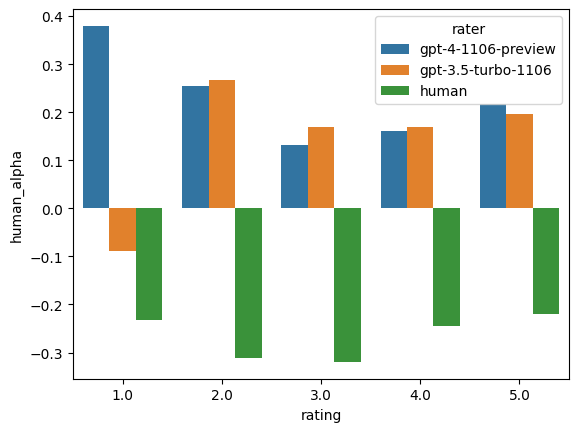

In [96]:
import seaborn as sns

sns.barplot(
    data=aggregated_agreement_df.loc[aggregated_agreement_df.rating > 0],
    x="rating",
    y="human_alpha",
    hue="rater",
    # horizontal orientation
    orient="v",
)

<Axes: xlabel='rating', ylabel='combined_alpha'>

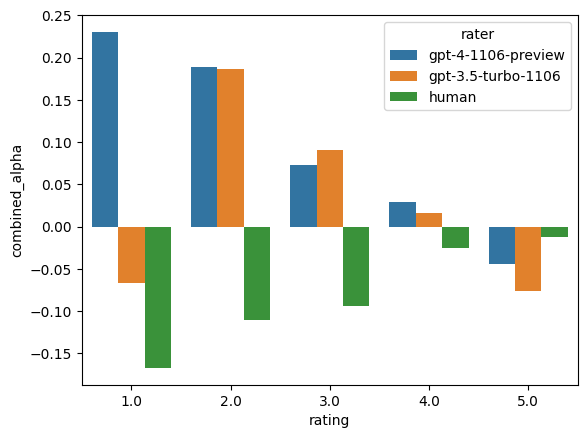

In [97]:
sns.barplot(
    data=aggregated_agreement_df.loc[aggregated_agreement_df.rating > 0],
    x="rating",
    y="combined_alpha",
    hue="rater",
    # horizontal orientation
    orient="v",
)

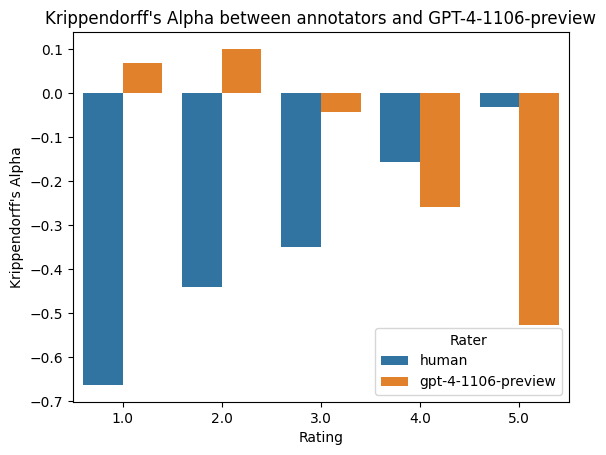

In [104]:
raters = ["human", "gpt-4-1106-preview"]
aggregated_agreement_df = aggregate_agreements(grouped_df, raters)


fig = sns.barplot(
    data=aggregated_agreement_df,
    x="rating",
    y="combined_alpha",
    hue="rater",
    orient="v",
)
fig.set_title("Krippendorff's Alpha between annotators and GPT-4-1106-preview")
fig.set_xlabel("Rating")
fig.set_ylabel("Krippendorff's Alpha")
fig.legend(title="Rater")

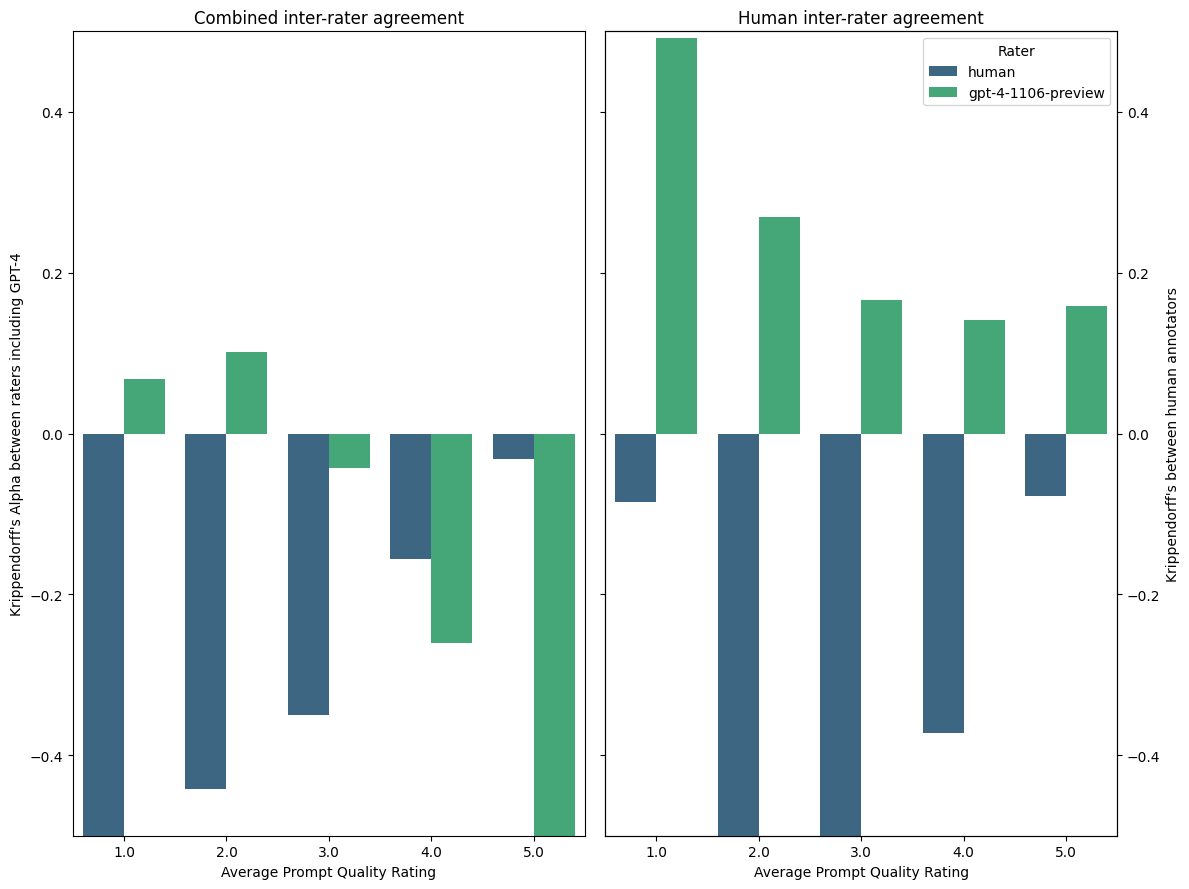

In [105]:
from matplotlib import pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 9), sharey=True)

x_axis_label = "Average Prompt Quality Rating"
y_axis_label = "Krippendorff's Alpha"

# Plot for combined alpha
sns.barplot(
    data=aggregated_agreement_df,
    x="rating",
    y="combined_alpha",
    hue="rater",
    orient="v",
    palette="viridis",
    # hatch="//",  # Set the hatch pattern for the first bar
    legend=False,
    ax=axes[0],  # Use the first subplot
)
axes[0].set_title("Combined inter-rater agreement")
axes[0].set_xlabel(x_axis_label)
axes[0].set_ylabel("Krippendorff's Alpha between raters including GPT-4")
axes[0].set_ylim(-0.5, 0.5)  # Set the limits of the y-axis
# Plot for human alpha
ax2 = axes[1].twinx()  # Create a twin Axes sharing the x-axis
# ax2 = axes[0].twiny()  # Create a twin Axes sharing the x-axis
ax2.set_ylim(axes[0].get_ylim())  # Set the limits of the twin Axes
sns.barplot(
    data=aggregated_agreement_df,
    x="rating",
    y="human_alpha",
    hue="rater",
    orient="v",
    palette="viridis",
    # hatch="\\\\",  # Set the hatch pattern for the second bar
    ax=ax2,  # Use the twin Axes
)
axes[1].set_title("Human inter-rater agreement")
axes[1].set_xlabel(x_axis_label)
ax2.legend(title="Rater", loc="upper right")  # Add a legend to the twin Axes

ax2.set_ylabel(
    "Krippendorff's between human annotators"
)  # Set the y-axis label for the twin Axes


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

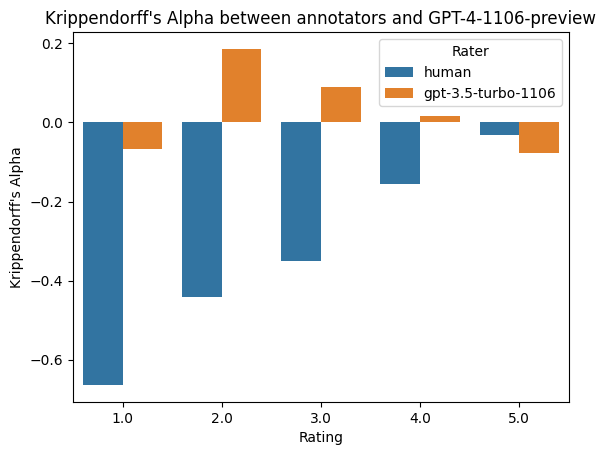

In [108]:
raters = ["human", "gpt-3.5-turbo-1106"]
aggregated_agreement_df = aggregate_agreements(grouped_df, raters)

fig = sns.barplot(
    data=aggregated_agreement_df,
    x="rating",
    y="combined_alpha",
    hue="rater",
    # horizontal orientation
    orient="v",
)

fig.set_title("Krippendorff's Alpha between annotators and GPT-4-1106-preview")
fig.set_xlabel("Rating")
fig.set_ylabel("Krippendorff's Alpha")
fig.legend(title="Rater")

# Synth - synth agreement

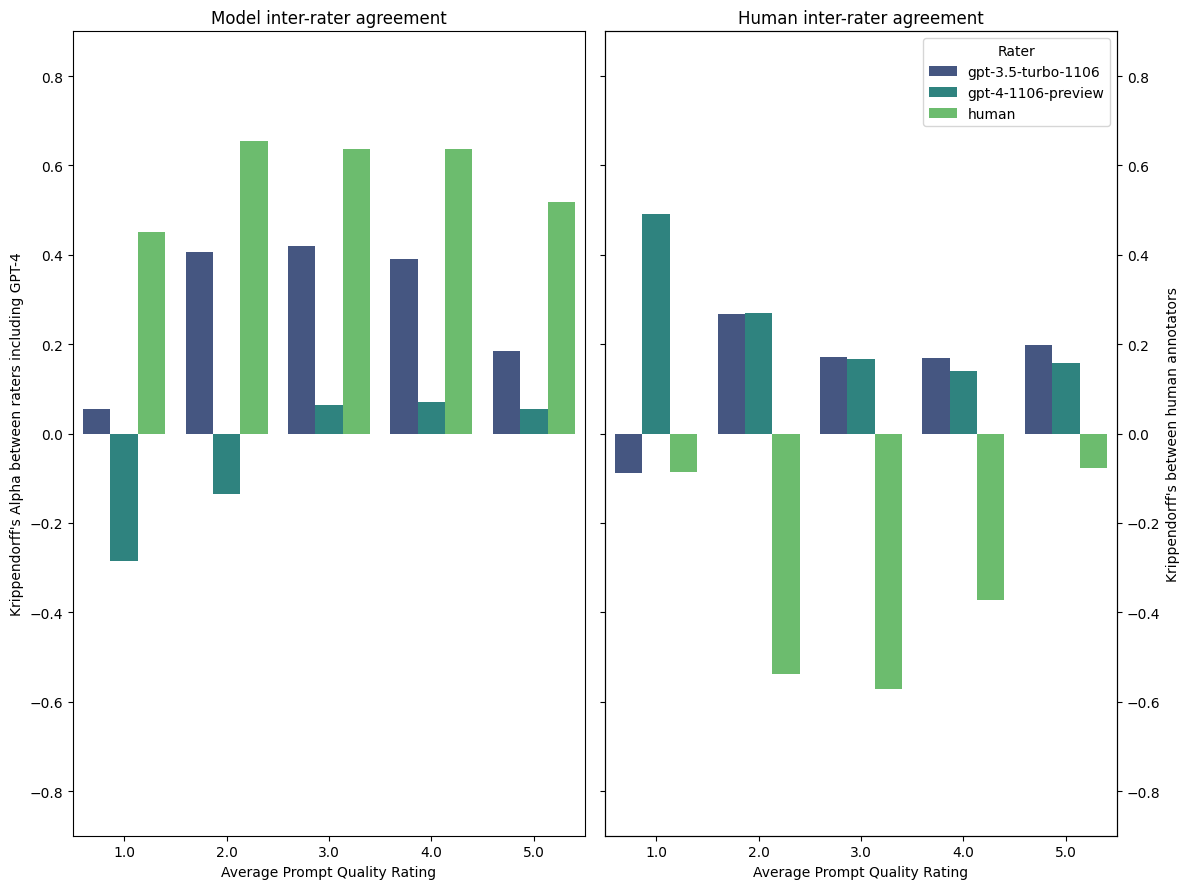

In [109]:
import seaborn as sns

raters = ["gpt-3.5-turbo-1106", "gpt-4-1106-preview", "human"]
aggregated_agreement_df = aggregate_agreements(grouped_df, raters)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 9), sharey=True)

x_axis_label = "Average Prompt Quality Rating"
y_axis_label = "Krippendorff's Alpha"

# Plot for combined alpha
sns.barplot(
    data=aggregated_agreement_df,
    x="rating",
    y="synth_alpha",
    hue="rater",
    orient="v",
    palette="viridis",
    # hatch="//",  # Set the hatch pattern for the first bar
    legend=False,
    ax=axes[0],  # Use the first subplot
)
axes[0].set_title("Model inter-rater agreement")
axes[0].set_xlabel(x_axis_label)
axes[0].set_ylabel("Krippendorff's Alpha between raters including GPT-4")
axes[0].set_ylim(-0.9, 0.9)  # Set the limits of the y-axis
# Plot for human alpha
ax2 = axes[1].twinx()  # Create a twin Axes sharing the x-axis
# ax2 = axes[0].twiny()  # Create a twin Axes sharing the x-axis
ax2.set_ylim(axes[0].get_ylim())  # Set the limits of the twin Axes
sns.barplot(
    data=aggregated_agreement_df,
    x="rating",
    y="human_alpha",
    hue="rater",
    orient="v",
    palette="viridis",
    # hatch="\\\\",  # Set the hatch pattern for the second bar
    ax=ax2,  # Use the twin Axes
)
axes[1].set_title("Human inter-rater agreement")
axes[1].set_xlabel(x_axis_label)
ax2.legend(title="Rater", loc="upper right")  # Add a legend to the twin Axes

ax2.set_ylabel(
    "Krippendorff's between human annotators"
)  # Set the y-axis label for the twin Axes


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Text Metrics

Let's explore text metrics and rater agreement. 

## Text Descriptives

In [114]:
import textdescriptives as td


func = lambda f: td.extract_metrics(text=f, lang="en", metrics=None)

td_dfs = df.loc[df.hash.drop_duplicates().index].input.apply(func)

ℹ No spacy model provided. Inferring spacy model for en.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 8.7 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
ℹ No spacy model provided. Inferring spacy model for en.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.7.1/en_core_web_lg-3.7.1-py3-none-any.whl (587.7 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kerne

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x747160061a80>>
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/py310/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


ℹ No spacy model provided. Inferring spacy model for en.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 5.4 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
ℹ No spacy model provided. Inferring spacy model for en.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.7.1/en_core_web_lg-3.7.1-py3-none-any.whl (587.7 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kerne

/home/ben/anaconda3/envs/py310/lib/python3.10/site-packages/textdescriptives/components/coherence.py:44: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


ℹ No spacy model provided. Inferring spacy model for en.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 8.5 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
ℹ No spacy model provided. Inferring spacy model for en.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.7.1/en_core_web_lg-3.7.1-py3-none-any.whl (587.7 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kerne